In [33]:
import os
import sys

import numpy as np

from scipy import stats
from scipy.stats import lognorm
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

sys.path.insert(0, os.path.join("..", "..", "..", "estimators"))

import entropy_estimators as ee

plt.rc("text", usetex=True)

### Multivariate lognormal distribution

To compute the PDF of the multivariate lognormal distribution, we start from the change of variables theorem:

$$ Y = \phi(X) $$

where $\phi$ is a regular bijective function. Then

$$ \pi_Y(y) = \pi_X(\phi^{-1}(y))\,|\det J_{\phi^{-1}}(y)| $$

where $J_{\phi^{−1}}$ is the Jacobian matrix of the inverse transformation. So for a multivariate lognormal random variable $Y = \exp(Z)$ where $Z\sim\mathcal{N}(\mu,\Sigma)$, we have

$$ \phi^{−1}(y) = \ln(y) $$

and so

$$ J_{\psi^{−1}}(y)= \mathrm{diag}\left(\frac{1}{y_1},\dots,\frac{1}{y_n}\right) $$

Hence

$$ |\det{J_{\psi^{−1}}}(y)| = \prod_{i=1}^n \frac{1}{y_i} $$

So, finally we have

$$ \pi_Y(y) = \frac{1}{\sqrt{(2\pi)^n\,\det(\Sigma)}}\,\exp\left(−\frac12(\ln(y)−\mu)^T \Sigma^{-1} (\ln(y)−\mu)\right)\,\prod_{i=1}^n \frac{1}{y_i} $$

## description of the approach

the goal is to setup a 2D lognormal with 
* variance corresponding to a factor $\alpha > 1$
* unit mean
* correlation coefficient $\rho = 0.9$ in linear scale.

In [34]:
alpha = 1.3

sigma_prior = np.log(alpha)
sigma2_prior = sigma_prior**2
mu_prior = - 0.5 * sigma2_prior
mu_vect_log = mu_prior * np.ones(2)

mu_vect_lin = np.ones(2)

rho_lin_prior = 0.9
cov_log_prior = np.log(1 + rho_lin_prior * (np.exp(sigma2_prior) - 1))

In [35]:
Sigma_log_prior = np.array([
    [sigma2_prior, cov_log_prior],
    [cov_log_prior, sigma2_prior]
])
Sigma_lin_prior = np.exp(Sigma_log_prior) - 1
Sigma_lin_prior

array([[0.07125944, 0.0641335 ],
       [0.0641335 , 0.07125944]])

In [36]:
Sigma_log_prior

array([[0.06883501, 0.06216085],
       [0.06216085, 0.06883501]])

In [37]:
upper_limit_lin = 2.5

In [38]:
a, b = 0.01, 5
n_points = 200

x, y = np.linspace(a, b, n_points), np.linspace(a, b, n_points)
X, Y = np.meshgrid(x, y)
Z = np.column_stack((X.flatten(), Y.flatten()))

y = np.linspace(0.01, 2*upper_limit_lin, 100*n_points)

list_y_test = [0.5, 1., 1.5]
colors = ["tab:blue", "tab:orange", "tab:red"]
assert len(colors) == len(list_y_test)


In [39]:
def multivariate_lognormal(Z, mu, sigma):
    ans = np.where(
        np.all(Z > 0, axis=-1),
        stats.multivariate_normal.pdf(np.log(Z), mu, sigma) * np.prod(1/Z, axis=-1),
        0.
    )
    return ans
# def multivariate_lognormal(Z, mu, sigma):
#     return stats.multivariate_normal.pdf(np.log(Z), mu, sigma) * np.prod(1/Z, axis=-1)

pdf = multivariate_lognormal(Z, mu_vect_log, Sigma_log_prior)
pdf = pdf.reshape(n_points, n_points)

pdf = pdf.reshape(n_points, n_points)
pdf /= pdf.sum() * ((b-a) / n_points)**2

pdf = np.where(pdf==0., 2.96623521e-065, pdf)

In [40]:
pdf

array([[2.96623521e-065, 1.04643311e-073, 6.94527468e-094, ...,
        2.96623521e-065, 2.96623521e-065, 2.96623521e-065],
       [1.04643311e-073, 1.56316943e-033, 8.23161557e-033, ...,
        2.96623521e-065, 2.96623521e-065, 2.96623521e-065],
       [6.94527468e-094, 8.23161557e-033, 4.16335903e-023, ...,
        5.81964074e-317, 1.11369709e-317, 2.14477355e-318],
       ...,
       [2.96623521e-065, 2.96623521e-065, 5.81964074e-317, ...,
        3.13920764e-010, 2.92967099e-010, 2.72961872e-010],
       [2.96623521e-065, 2.96623521e-065, 1.11369709e-317, ...,
        2.92967099e-010, 2.73908866e-010, 2.55666421e-010],
       [2.96623521e-065, 2.96623521e-065, 2.14477355e-318, ...,
        2.72961872e-010, 2.55666421e-010, 2.39068202e-010]])

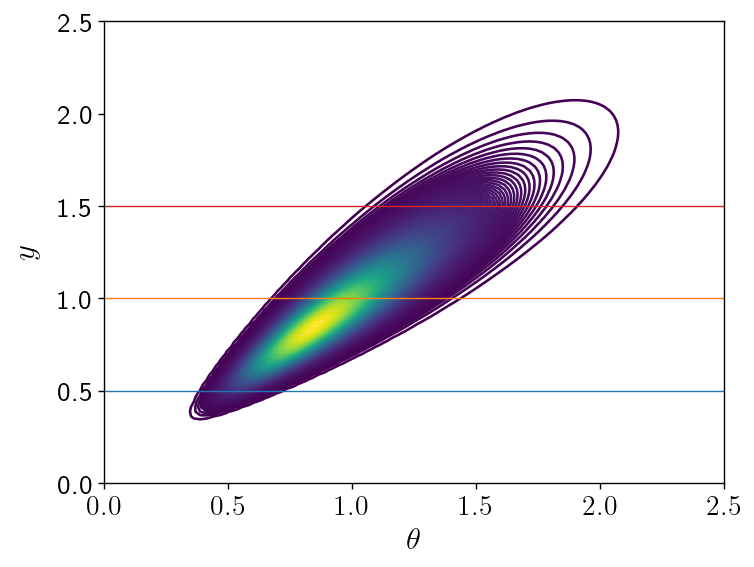

In [41]:
plt.figure(dpi=125)

# plt.contourf(X, Y, pdf, origin="lower", levels=10)
plt.contour(X, Y, pdf, origin="lower", levels=350)
# plt.colorbar()

plt.xlim([0., upper_limit_lin])
plt.ylim([0., upper_limit_lin])

plt.xlabel("$\\theta$", fontsize=18)
plt.ylabel("$y$", fontsize=18, labelpad=10)
plt.tick_params(labelsize=16)

w = 0.8
for c, y_test in zip(colors, list_y_test):
    plt.axhline(y_test, color=c, linewidth=w)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig("2d_pdf.png", bbox_inches="tight")
plt.show()

In [42]:
def compute_pdf(y, y_test):
    mu_test = mu_prior  + cov_log_prior / sigma2_prior * (np.log(y_test) -mu_prior)
    sigma2_test = sigma2_prior - cov_log_prior**2 / sigma2_prior
    rv_test = lognorm(scale=np.exp(mu_test), s=pow(sigma2_test, 0.5))
    pdf_test = rv_test.pdf(y)

    h_test = 0.5 * np.log2(2 * np.pi * np.e * sigma2_test * np.exp(2 * mu_test))
    print(y_test, rv_test.stats(), f"true entropy={rv_test.entropy() / np.log(2):.3f} bits, lognormal formula={h_test:.3f} bits")
    return pdf_test

def compute_pdf_prior(y, mu_prior, sigma2_prior):
    rv_prior = lognorm(scale=np.exp(mu_prior), s=pow(sigma2_prior, 0.5))
    pdf_prior = rv_prior.pdf(y)

    h_prior = 0.5 * np.log2(2 * np.pi * np.e * sigma2_prior * np.exp(2 * mu_prior))
    print("prior", rv_prior.stats(), f"true entropy={rv_prior.entropy() / np.log(2):.3f} bits, lognormal formula={h_prior:.3f} bits")
    return pdf_prior


pdf0 = compute_pdf_prior(y, mu_prior, sigma2_prior)
list_pdf_y_test = [compute_pdf(y, y_test=y_test) for y_test in list_y_test]

prior (0.9999999999999999, 0.07125944454555277) true entropy=0.067 bits, lognormal formula=0.067 bits
0.5 (0.5363721770842707, 0.003677374645867477) true entropy=-2.010 bits, lognormal formula=-2.010 bits
1.0 (1.0030180635909345, 0.012859465052552643) true entropy=-1.107 bits, lognormal formula=-1.107 bits
1.5 (1.4465266203032543, 0.02674596391931051) true entropy=-0.579 bits, lognormal formula=-0.579 bits


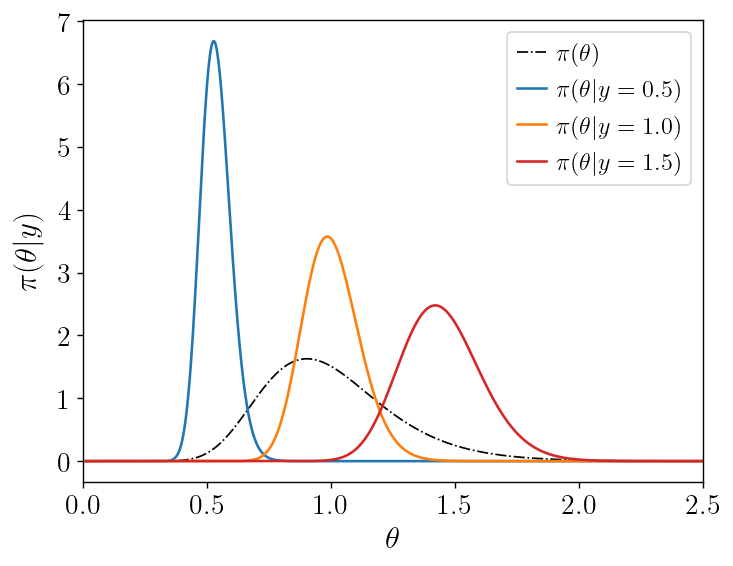

In [43]:
plt.figure(dpi=125)

plt.plot(y, pdf0, color="black", linewidth=1, linestyle="-.", label=f"$\\pi(\\theta)$")

for c, y_test, pdf_ in zip(colors, list_y_test, list_pdf_y_test):
    plt.plot(y, pdf_, color=c, label=f"$\\pi(\\theta|y={y_test:.1f})$")

plt.xlim([0., upper_limit_lin])

plt.xlabel("$\\theta$", fontsize=18)
plt.ylabel("$\pi(\\theta|y)$", fontsize=18, labelpad=8)
plt.tick_params(labelsize=16)

plt.legend(
    loc="upper right",
    fontsize=14,
    handlelength=1.2,
    handletextpad=0.4
)

plt.savefig("1d_pdfs.png", bbox_inches="tight")
plt.show()

# in a same subplot

In [44]:
from matplotlib.collections import LineCollection

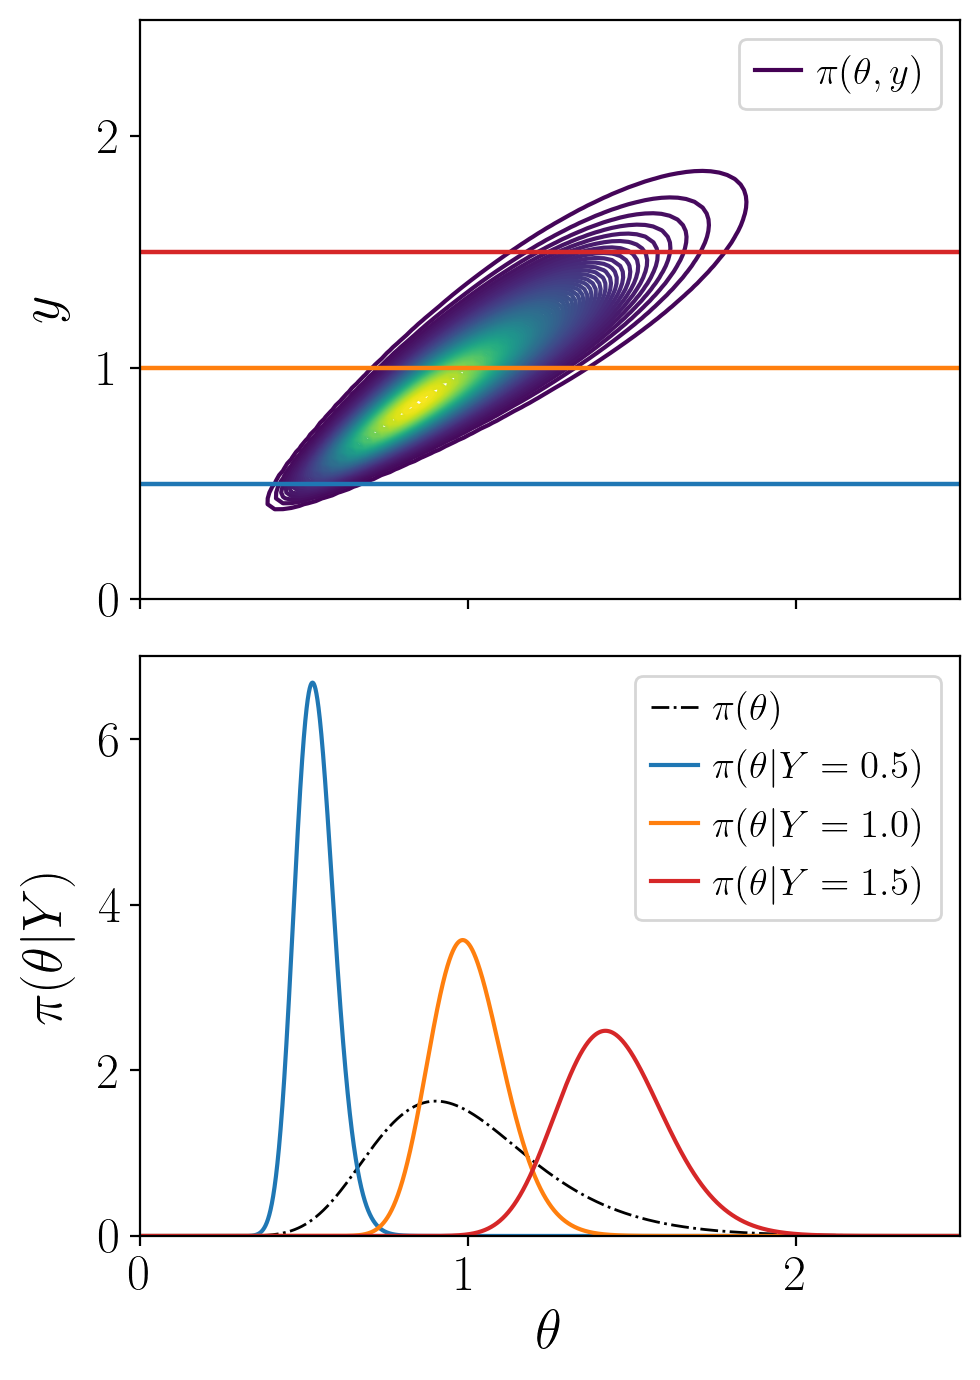

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(5,7), sharex=True, dpi=200)

size_axis_label = 20
size_tick_params = 18

# first plot
ax[0].contour(X, Y, pdf, origin="lower", levels=100)

w = 2*0.8
for c, y_test in zip(colors, list_y_test):
    ax[0].axhline(y_test, color=c, linewidth=w)

ax[0].set_ylabel("$y$", fontsize=size_axis_label, labelpad=10)

# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].set_xlim([0, upper_limit_lin])
ax[0].set_ylim([0, upper_limit_lin])
ax[0].set_yticks(list(range(3)))
ax[0].tick_params(labelsize=size_tick_params)

ax[0].plot([], [], color=plt.colormaps["viridis"](0), label=r"$\pi(\theta,y)$")
ax[0].legend(
    loc="upper right",
    fontsize=14,
    handlelength=1.2,
    handletextpad=0.4
)

# second plot
ax[1].plot(y, pdf0, color="k", linewidth=1, linestyle="-.", label=f"$\\pi(\\theta)$")

for c, y_test, pdf_ in zip(colors, list_y_test, list_pdf_y_test):
    ax[1].plot(y, pdf_, color=c, label=f"$\\pi(\\theta|Y={y_test:.1f})$")


ax[0].set_xticks(list(range(3)))
ax[0].set_yticks(list(range(3)))

ax[1].set_xlabel("$\\theta$", fontsize=size_axis_label)
ax[1].set_ylabel("$\pi(\\theta|Y)$", fontsize=size_axis_label, labelpad=8)
ax[1].tick_params(labelsize=size_tick_params)

ax[1].set_ylim([-0., 7.])

ax[1].legend(
    loc="upper right",
    fontsize=14,
    handlelength=1.2,
    handletextpad=0.4
)

plt.tight_layout()
plt.savefig("2d_pdf_and_1d_pdfs.png", bbox_inches="tight")

plt.show()

### Conditional entropy, mutual information and Fano bound

In [46]:
mu_y = mu_prior
sigma2_y = sigma2_prior

rv_y = lognorm(scale=np.exp(mu_y), s=pow(sigma2_y, 0.5))
entropy_y = rv_y.entropy() / np.log(2.)

f"{entropy_y:.4f}"

'0.0671'

In [47]:
D = 2
mu_joint = mu_vect_log * 1
sigma_joint = Sigma_log_prior * 1

entropy_joint = 0.5 * np.log2(
    (2 * np.pi * np.e)**D
    * np.linalg.det(sigma_joint)
    * np.exp(2 * np.sum(mu_joint))
)

f"{entropy_joint:.4f}"

'-1.0849'

In [48]:
entropy_conditional = entropy_joint - entropy_y

f"{entropy_conditional:.3f}"

'-1.152'

In [49]:
mi = 2 * entropy_y - entropy_joint
f"{mi:.3f}"

'1.219'

In [50]:
mi = entropy_y - entropy_conditional

# f"{mi:.3f}"
mi

1.2190893386500645

In [51]:
fano = 1 / (2 * np.pi * np.e) * np.exp(
    2 * np.log(2) * entropy_conditional # entropy_conditional
)
f"{fano:.4f}"

'0.0119'

### Regression: natural estimator

In [52]:
mean_theta = 1.

MSE_1 = 2 * mean_theta**2 + 2 * Sigma_lin_prior[0,0]
MSE_2 = 2 * (Sigma_lin_prior[0,1] + mean_theta**2)

print(MSE_1, MSE_2)
f"{MSE_1 - MSE_2:.4f}"

2.1425188890911055 2.128267000181995


'0.0143'

In [53]:
2.143 - 2.128

0.01499999999999968

# Regression: optimal estimator

In [54]:
from scipy import stats

mu = np.ones(2)
sigma = Sigma_lin_prior

def sample_multivariate_lognormal(size, mu, sigma):
    return np.exp(stats.multivariate_normal(mu, sigma).rvs(size))

In [55]:
def optimal_estimator(y):
    mu_test = mu_prior  + cov_log_prior / sigma2_prior * (np.log(y) -mu_prior)
    sigma2_test = sigma2_prior - cov_log_prior**2 / sigma2_prior

    return np.exp(mu_test + sigma2_test/2)

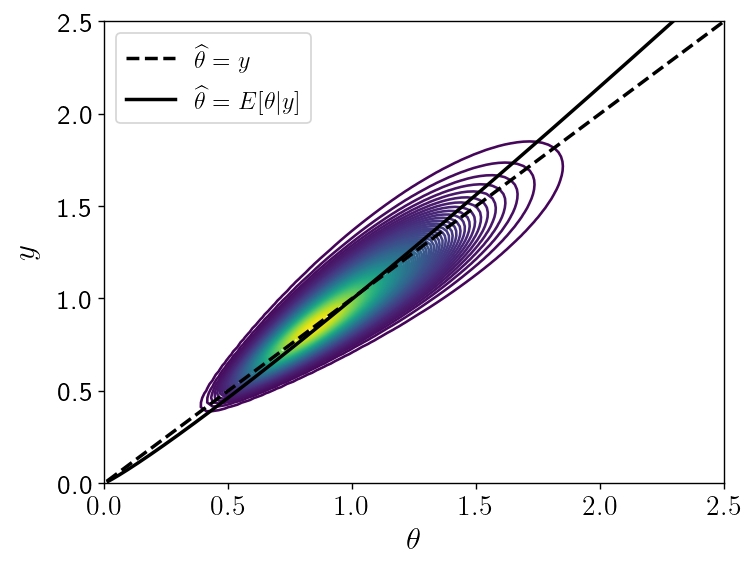

In [56]:
plt.figure(dpi=125)

plt.contour(X, Y, pdf, origin="lower", levels=100)
plt.plot(
    y, y, "k--", linewidth=2,
    label="$\\widehat{\\theta}= y$"
)
plt.plot(
    optimal_estimator(y), y, color="k", linewidth=2,
    label="$\\widehat{\\theta}= {E}[\\theta \\vert y]$"
)

plt.xlim([0, upper_limit_lin])
plt.ylim([0, upper_limit_lin])

plt.xlabel("$\\theta$", fontsize=18)
plt.ylabel("$y$", fontsize=18, labelpad=10)
plt.tick_params(labelsize=16)

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.legend(fontsize=14)

plt.savefig("2d_pdf_reg.png", bbox_inches="tight")
plt.show()

In [57]:
# mc_estimator_optimal_mse :
mu_lognorm = mu_vect_log * 1
sigma_lognorm = Sigma_log_prior*1

samples = sample_multivariate_lognormal(100_000_000, mu_lognorm, sigma_lognorm)


theta = samples[:, 0] *1
y = samples[:, 1] *1

# theta.mean(), theta.var(), y.mean(), y.var()

theta_est = optimal_estimator(y)

np.mean((theta - theta_est)**2)

0.013521873207437373

In [58]:
(0.0135 - 0.0119) / 0.0135 * 100

11.851851851851844

In [59]:
samples = sample_multivariate_lognormal(100_000, mu_lognorm, sigma_lognorm)


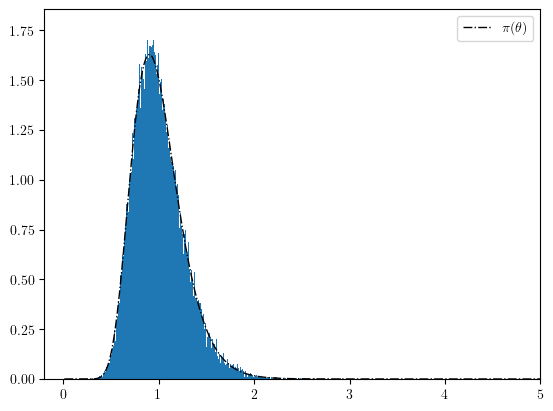

In [60]:
y_linspace = np.linspace(0.01, 5.5, 100*n_points)


plt.hist(samples[:, 1], density=True, bins=1000)
plt.plot(y_linspace, rv_y.pdf(y_linspace), color="black", linewidth=1, linestyle="-.", label=f"$\\pi(\\theta)$")

plt.xlim(-0.2, 5.)

plt.legend()
plt.show()

In [61]:
from tqdm import tqdm

n_iter = 100

eqms = []
for _ in tqdm(range(n_iter)):
    data = np.random.multivariate_normal(mu, sigma, size=1_000_000)
    data = np.exp(data)

    theta, y = data[:, 0], data[:, 1]
    error = theta - y

    eqms.append( np.mean(error**2) )

100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


In [62]:
print( np.mean(eqms)**0.5 )
# print( np.std(eqms) )

0.34782189367349764


/tmp/ipykernel_18122/254000411.py:4: RuntimeWarning: invalid value encountered in log
  stats.multivariate_normal.pdf(np.log(Z), mu, sigma) * np.prod(1/Z, axis=-1),


NameError: name 'h0' is not defined

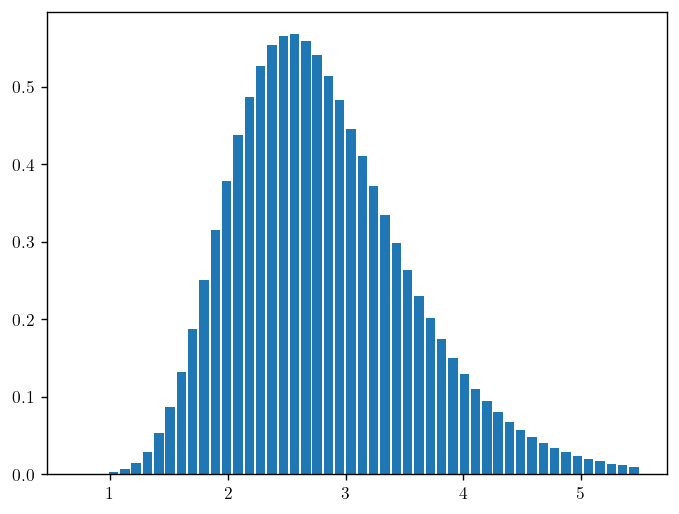

In [63]:
data = np.random.multivariate_normal(mu, sigma, size=10_000_000)
data = np.exp(data)

theta, _y = data[:, 0], data[:, 1]

filt = (-0.5 <= theta) & (theta <= 5.5)
theta, _y = theta[filt], _y[filt]

#

y = np.linspace(-0.5, 5.5, 10*n_points)

pdf0 = multivariate_lognormal(y[:, np.newaxis], mu[0], sigma[0, 0])

pdf1 = multivariate_lognormal(np.column_stack((1*np.ones_like(y), y)), mu, sigma)
pdf2 = multivariate_lognormal(np.column_stack((2*np.ones_like(y), y)), mu, sigma)
pdf3 = multivariate_lognormal(np.column_stack((3*np.ones_like(y), y)), mu, sigma)

pdf1 /= ((y[1]-y[0]) * pdf1.sum())
pdf2 /= ((y[1]-y[0]) * pdf2.sum())
pdf3 /= ((y[1]-y[0]) * pdf3.sum())

#

H, xticks = np.histogram(theta, bins=50, density=True)
xticks = (xticks[:-1] + xticks[1:])/2
H *= filt.mean()

#

plt.figure(dpi=125)

plt.bar(xticks, H, width=0.08)
plt.plot(y, pdf0, color="black", linewidth=1, linestyle="-.", label=f"$h(\\theta) = {h0:.1f}$ bits")

# plt.plot(y, pdf1, color="tab:red", label=f"$h(\\theta|y=1) = {h1:.1f}$ bits")
# plt.plot(y, pdf2, color="tab:green", label=f"$h(\\theta|y=2) = {h2:.1f}$ bits")
# plt.plot(y, pdf3, color="tab:orange", label=f"$h(\\theta|y=3) = {h3:.1f}$ bits")

plt.show()

In [ ]:
data = np.random.multivariate_normal(mu, sigma, size=10_000_000)
data = np.exp(data)

theta, _y = data[:, 0], data[:, 1]

a = 2
offset = 0.05

filt = (a-offset <= _y) & (_y <= a+offset)
theta, _y = theta[filt], _y[filt]

ee.entropy(theta)